# Buscaminas ⛏️💣💥
--------------------

***por: Dave y Laura***

In [1]:
!pip install termcolor

In [2]:
import random
import numpy              as np
import matplotlib.pyplot  as plt


from copy                 import deepcopy
from time                 import time, sleep
from itertools            import product, combinations
from tqdm.notebook        import tqdm
from scipy.signal         import convolve2d
from matplotlib.patches   import RegularPolygon
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display      import clear_output
from termcolor            import colored

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

## Definición de clases lógicas 

* _**<u>Clase descriptor</u>** (importante para codificar hechos-átomos, como una sola letra)_

In [3]:
class Descriptor :

    '''
    Codifica un descriptor de N argumentos mediante un solo caracter
    Input:  args_lista, lista con el total de opciones para cada
                     argumento del descriptor
            chrInit, entero que determina el comienzo de la codificación chr()
    Output: str de longitud 1
    '''

    def __init__ (self,args_lista,chrInit=256) :
        self.args_lista = args_lista
        assert(len(args_lista) > 0), "Debe haber por lo menos un argumento"
        self.chrInit = chrInit
        self.rango = [chrInit, chrInit + np.prod(self.args_lista)]

    def check_lista_valores(self,lista_valores) :
        for i, v in enumerate(lista_valores) :
            assert(v >= 0), f"Valores deben ser no negativos {lista_valores}"
            assert(v < self.args_lista[i]), f"Valor debe ser menor a máximo {self.args_lista[i]}, got {v}, {lista_valores}"

    def codifica(self,lista_valores) :
        self.check_lista_valores(lista_valores)
        cod = lista_valores[0]
        n_columnas = 1
        for i in range(0, len(lista_valores) - 1) :
            n_columnas = n_columnas * self.args_lista[i]
            cod = n_columnas * lista_valores[i+1] + cod
        return cod

    def decodifica(self,n) :
        decods = []
        if len(self.args_lista) > 1:
            for i in range(0, len(self.args_lista) - 1) :
                n_columnas = np.prod(self.args_lista[:-(i+1)])
                decods.insert(0, int(n / n_columnas))
                n = n % n_columnas
        decods.insert(0, n % self.args_lista[0])
        return decods

    def P(self,lista_valores) :
        codigo = self.codifica(lista_valores)
        return chr(self.chrInit+codigo)

    def inv(self,codigo) :
        n = ord(codigo)-self.chrInit
        return self.decodifica(n)



* _**<u>Clase Cláusula Definida</u>** (importante para manejar fórmulas lógicas en su descomposicón como precedente y consecuente)_

In [4]:
class ClausulaDefinida :
    '''
    Implementación de las cláusulas definidas
    Input: clausula, que es una cadena de la forma p1 Y ... Y pn > q
    '''

    def __init__(self, clausula) :
        self.nombre = clausula
        indice_conectivo = clausula.find('>')
        if indice_conectivo > 0:
            cuerpo = clausula[:indice_conectivo].split('Y')
            cabeza = clausula[indice_conectivo + 1:]
        else:
            cuerpo = clausula.split('Y')
            cabeza = ''
        self.cuerpo = cuerpo
        self.cabeza = cabeza

* _**<u>Clase LPQuery</u>** clase que permite manejar las reglas (conjunto de clausulas definidas), los átomos (conjuntos de hechos codificados en un string haciendo uso del descriptor) y los hechos (átomos que ya han sucedido, es decir que son verdaderos)_.

Cambiamos la implementación a una con diccionarios por que es más eficiente que listas.

In [5]:
class LPQuery:

    '''
    Implementación de una base de conocimiento.
    Input:  base_conocimiento_lista, que es una lista de cláusulas definidas
                de la forma p1 Y ... Y pn > q
            cods, un objeto de clase Descriptor
    '''

    def __init__(self, base_conocimiento_lista) :
        self.datos = {}
        self.reglas = {}
        self.atomos = {}
        for formula in base_conocimiento_lista:
            self.TELL(formula)

    def __str__(self) :
        cadena = 'Datos:\n'
        for dato in self.datos.keys():
            cadena += dato + '\n'
        cadena += '\nReglas:\n'
        
        for regla in self.reglas.keys():
            cadena += regla.nombre + '\n'
        return cadena

    def reglas_aplicables(self, head):
        return [r for r in self.reglas.keys() if r.cabeza == head]

    def test_objetivo(self, literal):
        return literal in self.datos.keys()

    def TELL(self, formula):
        indice_conectivo = formula.find('>')
        
        #si tiene precedente
        if indice_conectivo > 0:
            
            #hace una clausula con la fórmula
            clausula = ClausulaDefinida(formula)
            
            #añade la clausula al diccionario
            self.reglas[clausula] = None
            
            #para los elementos en el precedente
            #los mete como átomos
            for precedente in clausula.cuerpo:
                
                if '-' in precedente:
                    atomo = precedente[1:]
                else:
                    atomo = precedente
                self.atomos[precedente] = None
                
            #agrega el consecuente como un átomo
            if '-' in clausula.cabeza:
                atomo = clausula.cabeza[1:]
            else:
                atomo = clausula.cabeza
            self.atomos[clausula.cabeza] = None
             
        #si no tiene precedente, es decir, es un hecho
        else:
            
            for literal in formula.split('Y'):
                #añade el dato 
                self.datos[literal] = None
                
                if '-' in literal:
                    atomo = literal[1:]
                else:
                    atomo = literal
                    
                self.atomos[literal] = None


* _**<u>Otras funciones de búsqueda de solución</u>** Estas nos ayudarán a solucionar el problema, una vez planteemos todas nuestras reglas._

In [6]:
def pl_fc_entails(base, q) :
    count = {}
    for regla in list(base.reglas.keys()):
        count[regla.nombre] = len(regla.cuerpo)
        
    inferred = dict(zip(base.atomos, [False]*len(base.atomos)))
    queue = deepcopy(list(base.datos.keys()))
    
    #print(queue)
    while len(queue) > 0:
        p = queue.pop(0)
        #print(f"popped {p}")
        if p == q:
            return True
        elif inferred[p] == False:
            inferred[p] = True
            
            for regla in list(base.reglas.keys()):
                if p in regla.cuerpo:
                    count[regla.nombre] -= 1
                    if count[regla.nombre] == 0:
                        queue.append(regla.cabeza)
                        #print("added consequense")
    return False

def and_or_graph_search(objetivo, base):
    return or_search(objetivo, base, [])

def or_search(head, base, camino):
    if base.test_objetivo(head):
        return True
    elif head in camino:
        return False
    
    reglas = base.reglas_aplicables(head)
    #print(f"numero de reglas aplicables: {len(reglas)}")
    if not reglas:
        return False
    for regla in reglas:
        plan = and_search(regla.cuerpo, base, [head] + camino)
        if plan != False:
            return True
    return False

def and_search(literales, base, camino):
    for literal in literales:
        plan = or_search(literal, base, camino)
        if plan == False:
            return False
    return True

def ASK(objetivo, valor, base):
    ask = and_or_graph_search(objetivo, base)
    return (ask == valor)

* _**<u>Otras funciones útiles</u>** para ubicarnos en el mapa del buscaminas._

In [7]:
def truncar(x, n=8):
    if x < 0:
        return 0
    elif x > n-1:
        return n-1
    else:
        return x

def adyacentes(casilla, n):
    x,y = casilla
    
    x = truncar(x, n)
    y = truncar(y, n)
    xizq = truncar(x-1, n)
    xder = truncar(x+1, n)
    yarr = truncar(y+1, n)
    yaba = truncar(y-1, n)
    
    fila_arr   = [(xizq, yarr), (x, yarr), (xder, yarr)]
    fila_mitad = [(xizq, y),    (x, y),    (xder, y)]
    fila_abajo = [(xizq, yaba), (x, yaba), (xder, yaba)]

    filas = []
    filas += fila_arr
    filas += fila_mitad
    filas += fila_abajo
    
    filas = list(set(filas) - set([(x,y)]))
    filas.sort()
    return filas
    

In [8]:
adyacentes((2,6), 8)

[(1, 5), (1, 6), (1, 7), (2, 5), (2, 7), (3, 5), (3, 6), (3, 7)]

# Fórmulas ➕ ➖ ➗ 🟰

Aquí desarrollamos las limitaciones lógicas del juego para que los algoritmos se encarguen de buscar nuestra solución.

### Códigos:

* 9 = Casilla desconocida.
* 10 = Mina marcada
* 11 = Hay mina

In [9]:
desconocida_cod = 9
marcada_cod = 10
mina_cod = 11

1. **Esta regla de unicidad por casillas** nos indica que cada casilla solo puede tener un número.\
Sean de 0 a 8, o códigos de estar marcada o tener mina.

In [10]:
def unicidad_por_casillas(n: int, descriptor: Descriptor) -> list:
    
    """    
    Input:
        n = tamaño del tablero
        descriptor = clase encargada decodificar los átomos
    Output:
        reglas = lista de reglas
    """

    reglas = []

    for x in range(n):
        for y in range(n):
            for i in [ w for w in range(9)] + [mina_cod, marcada_cod]:
                for j in [ w for w in range(9)] + [mina_cod, marcada_cod]:
                    if i != j:
                        reglas += [f'{descriptor.P([x, y, i])}>-{descriptor.P([x, y, j])}']
    
    #nos quitamos de encima repetidos por si acaso
    return list(set(reglas))

2. **Esta regla tiene la forma:**
(casilla con X número de bombas) *Y* (casilla adyacente 1 no tiene bomba) *Y* ... *Y* (casilla adyacente n no tiene bomba) -***entonces***-  
(casilla adyacente w tiene bomba)

**En otras palabras:** Toma la casilla que se supone tiene X bombas adyacentes *(caso a consideración)*, después hace una Itoria de casos en que una casilla adyacente no tiene bomba y junta la Itoria con el caso a consideración.  
Para agregar como consecuente el hecho de que en una casilla de las adyacentes hay bomba.  

**Ayudándome a ver el juego desde la prespectiva de:** Sé que en esta casilla hay un número y en estas otras no hay bomba, entonces la bomba debe estar en aquella casilla.

In [11]:
def no_hay_minas(n: int, descriptor: Descriptor) -> list:
    
    """
        
    """
    
    formulas = []
    
    for x in range(n):
        for y in range(n):
            
            #para cada (x,y) queremos saber quienes son los vecinos, 
            #y para cada vecino vamos a contemplar los casos en que estos 
            #tienen minas (de 1 a 8 minas).
            
            ady = adyacentes(casilla = (x,y),
                             n = n)
            
            #esto lo usamos para hacer más bonitas las cosas
            ady_set = set(ady)
            
            for nminas in range(1, 9):
                
                #codificación de la posición en la que se está, con 
                #n_minas adyacentes
                cod =  f'{descriptor.P([x, y, nminas])}'
                

                #hay muchos casos en los que pueden haber minas alrededor
                #para esto hacemos las combinaciones, esto retorna una lista
                #de tuplas de la forma:
                # [ ((xa,yb) ... (xe,yf)),  #combinación1 de casillas donde hay minas
                #   ((xc,yd) ... (xg,yh)),  #combinación2 de casillas donde hay minas
                #            ...          ]
                combs = combinations(ady, nminas)

                #tomamos una combinación de casillas donde hay minas
                #y hacemos las reglas
                for comb in combs:
                    
                    #conjunto de casillas donde hay minas
                    comb_set = set(comb)
                    
                    #string que contiene la concatenación 
                    #de casillas sin mina 
                    itoria_sin_mina = ''
                    
                    for cord_sin_mina in (ady_set - comb_set):
                        
                        xi , yi = cord_sin_mina
                        itoria_sin_mina += f'Y-{descriptor.P([xi, yi, mina_cod])}'
                    
                    #regla de la forma:
                    #caso_actual Y sin minas   
                    #(esto forma el precedente de nuestra regla)
                    precedente = cod + itoria_sin_mina
                
                    #ahora creamos el consecuente
                    consecuentes = []
                    
                    for comb_con_mina in comb:
                        xi , yi = comb_con_mina
                        consecuentes += [f'{descriptor.P([xi, yi, mina_cod])}']
                        
                    formulas += [f'{precedente}>{consecuencia}' \
                                 for consecuencia in consecuentes]

            #ya contemplamos los diversos casos 
            #cuando hay minas adyacentes. El siguiente caso es más sencillo
            #y es cuando una casilla no tiene minas adyacentes
            
            for veci in ady:
                
                #aquí digo: dado que mi número en esta casilla es cero,
                #en esta otra adyacente no hay mina. (esto para todas las adyacentes)
                formulas += [f'{descriptor.P([x, y, 0])}>\
                               -{descriptor.P([veci[0], veci[1], mina_cod])}']
         
    return list(set(formulas))

In [12]:
def no_hay_minas222(n: int, descriptor: Descriptor, casillas: list) -> list:
    
    """
        
    """
    
    formulas = []
    
    for casilla in casillas:
        
        x, y, m = casilla
        #para cada (x,y) queremos saber quienes son los vecinos, 
        #y para cada vecino vamos a contemplar los casos en que estos 
        #tienen minas (de 1 a 8 minas).

        ady = adyacentes(casilla = (x,y),
                         n = n)

        #esto lo usamos para hacer más bonitas las cosas
        ady_set = set(ady)

        for nminas in [m]:
            
            if nminas == 0:
                break

            #codificación de la posición en la que se está, con 
            #n_minas adyacentes
            cod =  f'{descriptor.P([x, y, nminas])}'


            #hay muchos casos en los que pueden haber minas alrededor
            #para esto hacemos las combinaciones, esto retorna una lista
            #de tuplas de la forma:
            # [ ((xa,yb) ... (xe,yf)),  #combinación1 de casillas donde hay minas
            #   ((xc,yd) ... (xg,yh)),  #combinación2 de casillas donde hay minas
            #            ...          ]
            combs = combinations(ady, nminas)

            #tomamos una combinación de casillas donde hay minas
            #y hacemos las reglas
            for comb in combs:

                #conjunto de casillas donde hay minas
                comb_set = set(comb)

                #string que contiene la concatenación 
                #de casillas sin mina 
                itoria_sin_mina = ''

                for cord_sin_mina in (ady_set - comb_set):

                    xi , yi = cord_sin_mina
                    itoria_sin_mina += f'Y-{descriptor.P([xi, yi, mina_cod])}'

                #regla de la forma:
                #caso_actual Y sin minas   
                #(esto forma el precedente de nuestra regla)
                precedente = cod + itoria_sin_mina

                #ahora creamos el consecuente
                consecuentes = []

                for comb_con_mina in comb:
                    xi , yi = comb_con_mina
                    consecuentes += [f'{descriptor.P([xi, yi, mina_cod])}']

                formulas += [f'{precedente}>{consecuencia}' \
                             for consecuencia in consecuentes]

        #ya contemplamos los diversos casos 
        #cuando hay minas adyacentes. El siguiente caso es más sencillo
        #y es cuando una casilla no tiene minas adyacentes

        for veci in ady:
            #aquí digo: dado que mi número en esta casilla es cero,
            #en esta otra adyacente no hay mina. (esto para todas las adyacentes)
            formulas += [f'{descriptor.P([x, y, 0])}>\
                           -{descriptor.P([veci[0], veci[1], mina_cod])}']
         
    return list(set(formulas))

3. **Esta regla tiene la forma:**  
(casilla con X número de bombas) *Y* (casilla adyacente 1 tiene bomba) *Y* ... *Y* (casilla adyacente n tiene bomba) -***entonces***-  
(casilla adyacente w no tiene bomba).

**En otras palabras:** Toma la casilla que se supone tiene X bombas adyacentes *(caso a consideración)*, después hace una Itoria de casos en que una casilla tiene bombas adyacentes y junta la Itoria con el caso a consideración.  
Para agregar como consecuente el hecho de que en una casilla de las adyacentes no hay bomba.  

**Ayudándome a ver el juego desde la prespectiva de:** Sé que en esta casilla hay un número y en estas otras hay bomba, entonces no debe haber bomba en aquella casilla. Este es el caso complementario de ver el juego.

In [13]:
def si_hay_minas(n: int, descriptor: Descriptor) -> list:
    
    """
        
    """
    
    formulas = []
    
    for x in range(n):
        for y in range(n):
            
            #para cada (x,y) queremos saber quienes son los vecinos, 
            #y para cada vecino vamos a contemplar los casos en que estos 
            #tienen minas (de 1 a 8 minas).
            
            ady = adyacentes(casilla = (x,y),
                             n = n)
            
            #esto lo usamos para hacer más bonitas las cosas
            ady_set = set(ady)
            
            for nminas in range(1, 9):
                
                #codificación de la posición en la que se está, con 
                #n_minas adyacentes
                cod =  f'{descriptor.P([x, y, nminas])}'
                

                #hay muchos casos en los que pueden haber minas alrededor
                #para esto hacemos las combinaciones, esto retorna una lista
                #de tuplas de la forma:
                # [ ((xa,yb) ... (xe,yf)),  #combinación1 de casillas donde hay minas
                #   ((xc,yd) ... (xg,yh)),  #combinación2 de casillas donde hay minas
                #            ...          ]
                combs = combinations(ady, nminas)

                #tomamos una combinación de casillas donde hay minas
                #y hacemos las reglas
                for comb in combs:
                    
                    #conjunto de casillas donde hay minas
                    comb_set = set(comb)
                    
                    #string que contiene la concatenación 
                    #de casillas con mina 
                    itoria_con_mina = ''
                    
                    for cord_con_mina in comb_set:
                        
                        xi , yi = cord_con_mina                        
                        itoria_con_mina += f'Y{descriptor.P([xi, yi, mina_cod])}'
                    
                    #regla de la forma:
                    #caso_actual Y con minas   
                    #(esto forma el precedente de nuestra regla)
                    precedente = cod + itoria_con_mina
                
                    #ahora creamos el consecuente
                    consecuentes = []
                    
                    for cord_sin_mina in (ady_set - comb_set):
                        xi , yi = cord_sin_mina
                        consecuentes += [f'-{descriptor.P([xi, yi, mina_cod])}']
                        
                    formulas += [f'{precedente}>{consecuencia}' \
                                 for consecuencia in consecuentes]
         
    return list(set(formulas))

In [14]:
def si_hay_minas222(n: int, descriptor: Descriptor, casillas: list) -> list:
    
    """
        
    """
    
    formulas = []
    
    for casilla in casillas:
        
        x, y, m = casilla
        #para cada (x,y) queremos saber quienes son los vecinos, 
        #y para cada vecino vamos a contemplar los casos en que estos 
        #tienen minas (de 1 a 8 minas).

        ady = adyacentes(casilla = (x,y),
                         n = n)

        #esto lo usamos para hacer más bonitas las cosas
        ady_set = set(ady)

        for nminas in [m]:
            
            if nminas == 0:
                break
            
            #codificación de la posición en la que se está, con 
            #n_minas adyacentes
            cod =  f'{descriptor.P([x, y, nminas])}'


            #hay muchos casos en los que pueden haber minas alrededor
            #para esto hacemos las combinaciones, esto retorna una lista
            #de tuplas de la forma:
            # [ ((xa,yb) ... (xe,yf)),  #combinación1 de casillas donde hay minas
            #   ((xc,yd) ... (xg,yh)),  #combinación2 de casillas donde hay minas
            #            ...          ]
            combs = combinations(ady, nminas)

            #tomamos una combinación de casillas donde hay minas
            #y hacemos las reglas
            for comb in combs:

                #conjunto de casillas donde hay minas
                comb_set = set(comb)

                #string que contiene la concatenación 
                #de casillas con mina 
                itoria_con_mina = ''

                for cord_con_mina in comb_set:

                    xi , yi = cord_con_mina                        
                    itoria_con_mina += f'Y{descriptor.P([xi, yi, mina_cod])}'

                #regla de la forma:
                #caso_actual Y con minas   
                #(esto forma el precedente de nuestra regla)
                precedente = cod + itoria_con_mina

                #ahora creamos el consecuente
                consecuentes = []

                for cord_sin_mina in (ady_set - comb_set):
                    xi , yi = cord_sin_mina
                    consecuentes += [f'-{descriptor.P([xi, yi, mina_cod])}']

                formulas += [f'{precedente}>{consecuencia}' \
                             for consecuencia in consecuentes]
         
    return list(set(formulas))

# Interfaz del buscaminas 🐱‍💻

Es prácticamente la misma interfaz original pero manejando un indexado de las matrices normal.
Resulta que la parte gráfica del juego tiene un indexado un poco muy anormal, y esto nos estaba haciendo sufrir, entonces internamente hicimos que funcionara con matrices de numpy y un indexado tipo numpy y tipo python de toda la vida.

In [15]:
class Buscaminas():
    
    def __init__(self, width=8, height=8, num_minas=10):
        
        #lista de casillas de la matriz
        self.casillas = [(x, y) for x in range(width) for y in range(height)]
        
        self.width = width
        self.height = height
        self.num_minas = num_minas
        self.lugar_seleccionable = width * height #- num_minas
        
        self.juego_activo = True
        self.transicion_bool = True

        self.flags = np.zeros((self.width, self.height), dtype=bool)
        self.conocidas = np.zeros((self.width, self.height), dtype=bool)
        self.numeros = np.zeros((self.width, self.height), dtype=int)
        
        i = 0
        while i < num_minas:
            x = random.randint(0, self.width-1)
            y = random.randint(0, self.height-1)
            
            #si la casilla seleccionada aleatoriamente no tiene una
            #bomba entonces la agrega como casilla con bomba
            if self.numeros[x][y] != mina_cod:
                self.agregar_mina((x, y))
                i += 1
            else:
                i -= 1
                
    # la gente que hizo la librería de UI y que da la ubicación de las cosas
    # está muy enferma de la cabeza y tiene el indexado completamente al revés 
    # entonces estas funciones ayudan traduciendo los indexados a algo con sentido
    # tanto para manejar matrices como para poder plotear cosas.
    def translate_from_ui_click_to_matrix_cordinate(self, row, col):
        return (self.height - col - 1, row)

    def translate_from_matrix_cordinate_to_ui_click(self, row, col):
        return (col, self.height - row - 1)
    
    def agregar_mina(self, casilla):
        x, y = casilla
        
        #marco la casilla con el número 11 que me indica que tiene 
        #una bomba
        self.numeros[x][y] = mina_cod
        
        #ahora busco aumentar los números al rededor de la casilla
        #que he marcado con bomba
        for x1,y1 in adyacentes((x,y), self.width):
            #si es de las casillas sin bombas, entonces aumentele 
            #el contador
            if self.numeros[x1][y1] != mina_cod:
                self.numeros[x1][y1] += 1
    
    
    def pintar_todo(self):
        covered_color = '#DDDDDD'
        uncovered_color = '#AAAAAA'
        edge_color = '#888888'
        count_colors = ['none', 'blue', 'green', 'red', 'darkblue',
                        'darkred', 'darkgreen', 'black', 'black']
        flag_vertices = np.array([[0.25, 0.2], [0.25, 0.8],
                                  [0.75, 0.65], [0.25, 0.5]])
        
        fig = plt.figure(figsize=((self.width + 2) / 3., (self.height + 2) / 3.))
        ax = fig.add_axes((0.05, 0.05, 0.9, 0.9),
                           aspect='equal', frameon=False,
                           xlim=(-0.05, self.width + 0.05),
                           ylim=(-0.05, self.height + 0.05))
        
        for axis in (ax.xaxis, ax.yaxis):
            axis.set_major_formatter(plt.NullFormatter())
            axis.set_major_locator(plt.NullLocator())
            
         
        # Create the grid of squares
        squares = np.array([[RegularPolygon((i + 0.5, j + 0.5),
                                             numVertices=4,
                                             radius=0.5 * np.sqrt(2),
                                             orientation=np.pi / 4,
                                             ec=edge_color,
                                             fc=covered_color)
                                  for j in range(self.height)]
                                 for i in range(self.width)])
        [ax.add_patch(sq) for sq in squares.flat]
        
        # Cargando imagen bomba
        arr_img_bomb = plt.imread("./imagenes/bomb.png", format='png')
        image_bomb = OffsetImage(arr_img_bomb, zoom=0.03)
        image_bomb.image.ax = ax
        
        # Cargando imagen bandera
        arr_img_flag = plt.imread("./imagenes/flag.png", format='png')
        image_flag = OffsetImage(arr_img_flag, zoom=0.03)
        image_flag.image.ax = ax
        
        # Pintando las casillas
        for casilla in self.casillas:
            x, y = casilla
            uix, uiy = self.translate_from_matrix_cordinate_to_ui_click(x,y)
            
            #si tiene bomba
            if self.numeros[x][y] == mina_cod:
                
                #si el juego no está activo
                if not self.juego_activo:
                    
                    #pinta la bandera si la tiene
                    if self.flags[x][y] == True:
                        ab = AnnotationBbox(image_flag, [uix + 0.5, uiy + 0.5], frameon=False)
                        ax.add_artist(ab)
                    #pinta la bomba si la tiene
                    else:
                        ab = AnnotationBbox(image_bomb, [uix + 0.5, uiy + 0.5], frameon=False)
                        ax.add_artist(ab)
                        
                #si el juego está activo
                #pinto la bomba
                else:
                    ab = AnnotationBbox(image_bomb, [uix + 0.5, uiy + 0.5], frameon=False)
                    ax.add_artist(ab)
            
            #si no tiene bomba
            else:
                
                #si el juego no está activo
                if not self.juego_activo:
                    
                    #pinta una bandera si la tiene
                    if self.flags[x][y] == True:
                            ab = AnnotationBbox(image_flag, [uix + 0.5, uiy + 0.5], frameon=False)
                            ax.add_artist(ab)
                    
                    #si tiene un numero y este no tiene color 
                    #que le corresponda entonces pinte gris
                    elif count_colors[self.numeros[x][y]] == None:
                        
                            ax.text(uix + 0.5, uiy + 0.5, str(self.numeros[x][y]),
                             color=count_colors[self.numeros[x][y]],
                             ha='center', va='center', fontsize=18,
                             fontweight='bold')
                    
                    #si el numero tiene un color 
                    #entonces lo pinta con su colorcito
                    else:
                        ax.text(uix + 0.5, uiy + 0.5, str(self.numeros[x][y]),
                                 color=count_colors[self.numeros[x][y]],
                                 ha='center', va='center', fontsize=18,
                                 fontweight='bold')
                        
                #si el juego está activo
                #pinta el número con su color directamente
                else:
                    ax.text(uix + 0.5, uiy + 0.5, str(self.numeros[x][y]),
                             color=count_colors[self.numeros[x][y]],
                             ha='center', va='center', fontsize=18,
                             fontweight='bold')
                
        #si el juego ya se acabó 
        if not self.juego_activo:
            
            #pone en rojo los errores que tuvo el usuario
            
            #pone en rojo las casillas que no tenían bandera
            #y también las que no tenían bomba pero si bandera
            for casilla in self.casillas:
                x, y = casilla
                uix, uiy = self.translate_from_matrix_cordinate_to_ui_click(x,y)

                if (self.numeros[x][y] == mina_cod) and (~self.flags[x][y]):
                    squares[uix, uiy].set_facecolor('red')
                    
                elif (self.numeros[x][y] != mina_cod) and (self.flags[x][y]):  
                    squares[uix, uiy].set_facecolor('red')
        return ax
    
    
    def pintar_casilla(self):
        covered_color = '#DDDDDD'
        uncovered_color = '#AAAAAA'
        edge_color = '#888888'
        count_colors = ['none', 'blue', 'green', 'red', 'darkblue',
                        'darkred', 'darkgreen', 'black', 'black']
        if self.juego_activo:
            flag_vertices = np.array([[0.25, 0.2], [0.25, 0.8],
                                      [0.75, 0.65], [0.25, 0.5]])

            fig = plt.figure(figsize=((self.width + 2) / 3., (self.height + 2) / 3.))
            ax = fig.add_axes((0.05, 0.05, 0.9, 0.9),
                               aspect='equal', frameon=False,
                               xlim=(-0.05, self.width + 0.05),
                               ylim=(-0.05, self.height + 0.05))

            for axis in (ax.xaxis, ax.yaxis):
                axis.set_major_formatter(plt.NullFormatter())
                axis.set_major_locator(plt.NullLocator())


            # Create the grid of squares
            squares = np.array([[RegularPolygon((i + 0.5, j + 0.5),
                                                     numVertices=4,
                                                     radius=0.5 * np.sqrt(2),
                                                     orientation=np.pi / 4,
                                                     ec=edge_color,
                                                     fc=covered_color)
                                      for j in range(self.height)]
                                     for i in range(self.width)])
            [ax.add_patch(sq) for sq in squares.flat]

            # Cargando imagen bomba
            arr_img_bomb = plt.imread("./imagenes/bomb.png", format='png')
            image_bomb = OffsetImage(arr_img_bomb, zoom=0.03)
            image_bomb.image.ax = ax
            
            # Cargando imagen bandera
            arr_img_flag = plt.imread("./imagenes/flag.png", format='png')
            image_flag = OffsetImage(arr_img_flag, zoom=0.03)
            image_flag.image.ax = ax

            # Pintando las casillas
            for casilla in self.casillas:
                x, y = casilla
                uix, uiy = self.translate_from_matrix_cordinate_to_ui_click(x,y)

                
                #si la casilla es conocida (ha sido seleccionada)
                if self.conocidas[x][y]:
                    squares[uix, uiy].set_facecolor(uncovered_color)
                    ab = AnnotationBbox(image_flag, [uix + 0.5, uiy + 0.5], frameon=False)
                    
                    #si la casilla conocida tiene bandera
                    #añade la bandera
                    if self.flags[x][y] == True:
                        ax.add_artist(ab)
                    
                    #si la casilla no tiene bandera entonces
                    #la quita
                    else:
                        try:
                            ax.patches.remove(ab)
                        except: pass
                        
                    
                    #si no tiene bomba y tampoco bandera 
                    #entonces dibuja el número
                    if (self.numeros[x][y] != mina_cod) and (self.flags[x][y] == False):
                        
                        ax.text(uix + 0.5, uiy + 0.5, str(self.numeros[x][y]),
                                 color=count_colors[self.numeros[x][y]],
                                 ha='center', va='center', fontsize=18,
                                 fontweight='bold')
            return ax
        else: 
            None
    
    def agregar_quitar_bandera(self, casilla):
        
        x, y = casilla
        #matriz con la posición de las bombas
        bombas = (self.numeros == mina_cod)

        self.transicion_bool = False
        
        #estoy quitando una bandera y dejandola como 
        #seleccionable
        if self.flags[x][y]:
            self.lugar_seleccionable += 1
        
        #estoy poniendo una bandera y así quitando 
        #un lugar seleccionable
        if not self.flags[x][y]:
            self.lugar_seleccionable -= 1
        
        
        #si el juego está activo
        #cambia el estado de ser conocido 
        #y de tener una bandera en esa casilla
        if self.juego_activo:
            self.conocidas[x][y] = ~self.conocidas[x][y]
            self.flags[x][y] = ~self.flags[x][y]
        
        #si ya no hay más lugares seleccionables
        #entonces se determina que el juego ha acabado
        if self.lugar_seleccionable == 0:
            self.juego_activo = False
            if np.all(self.flags == bombas):
                print("¡Felicidades! Juego terminado")
            else:
                print("Perdiste, ¡Juego terminado!")
            #self.pintar_todo()
        
    def transicion(self, casilla):
        self.transicion_bool = True
        x, y = casilla
        
        #matriz con la posición de las bombas
        bombas = (self.numeros == mina_cod)
        self.conocidas[x][y] = True
        
        
        if (self.juego_activo == True) and (self.flags[x][y] == False):

            if self.numeros[x][y] == mina_cod:
                self.juego_activo = False
                print("Perdiste, ¡Juego terminado!")
                ax = self.pintar_todo()
                
            if self.lugar_seleccionable == 0:
                self.juego_activo = False
                if np.all(self.flags == bombas):
                    print("¡Felicidades! Juego terminado")
                else:
                    print("Perdiste, ¡Juego terminado!")
            
            if self.numeros[x][y] == 0:
                for x1, y1 in adyacentes(casilla, self.width):
                    if not self.conocidas[x1][y1]:
                        self.transicion((x1,y1))

            self.lugar_seleccionable -= 1

                        
        elif self.juego_activo == True and self.flags[x][y] == True:
            print("La casilla tiene una bandera, pruebe otra movida.")
        else:
            print("El juego ha terminado.")
            
    def random_click(self):
        
        x = random.randint(0, self.width - 1) 
        y = random.randint(0, self.height - 1)
        
        return (x, y)
    
    def valor_cord(self, x, y):
        return self.numeros[x][y]
    
    def gano(self):
        
        bombas = (self.numeros == mina_cod)
        
        #si no hay más movimientos y todas las banderas tienen bomba
        #indica que gano
        if (self.lugar_seleccionable == 0) and (self.flags == bombas).all():
            return True
        
        #si descubrí todo lo que no tenía bomba
        if ((~ bombas) == self.conocidas).all():
            return True
        
        
    def casilla_seleccionada(self, x, y):
        return (self.conocidas[x][y] == True) or (self.flags[x][y] == True)
    
    
    def encontrar_borde(self):
        
        conocido = np.where(self.conocidas == True)   
        cord_conocidos = set(list(zip(conocido[0], conocido[1])))
        ady = set()
        
        for cord_conocida in cord_conocidos:
            ady_de_conocida = set(adyacentes(cord_conocida, self.width))
            ady = ady.union(ady_de_conocida)
            
        return list(ady - cord_conocidos)
    
    def marcada(self, x, y):
        return self.flags[x][y]    

# Clase Agente 🤸🤸🤸

Es nuestra clase principal, aquí definimos al agente que juega buscaminas. 
Para resumirlo **el agente juega así:**

1. Expande una ***casilla aleatoria*** como primer paso.
2. Si tubo mala suerte y expandió una casilla con un número, le damos ***una segunda oportunidad*** de expandir aleatoriamente, si lo anterior no se dá seguimos directamente con el caso ***(3)***.
3. Con lo descubierto en ***(1)*** y ***(2)*** actualizamos el conocimiento del agente a través de la función actualizar conocimiento.
4. ***Obtengo la lista de casillas que desconozco***, en particular las que están justo al borde de las casillas descubiertas y empiezo a preguntarme sobre cada una de las casillas del borde desconocido.
5. La -***primera pregunta***- es si puedo expandir la casilla desconocida seleccionada, si no puedo expandirla con certeza entonces me hago la -***segunda pregunta***- ¿puedo marcarla? Si tampoco puedo marcarla con certeza entonces paso a analizar la siguiente casilla.
6. repito el paso ***(5)*** hasta que me quede sin casillas del borde desconocido, y ***si en ningún momento pude tomar una acción*** entonces hago una expansión aleatoria sobre las casillas que no conozco, y con esta información actualizo el conocimiento. ***Si en algún momento pude marcar o expandir con certeza*** entonces dejo de buscar en las vecinas y actualizo el conocimiento adquirido, para nuevamente empezar desde el paso ***(4)*** hasta que pierda o gane el juego.

In [16]:
class Agente():
    
    def __init__(self, buscaminas: Buscaminas,
                       conocimiento: LPQuery,
                       descriptor,
                       verboso: bool):
           
        self.buscaminas = buscaminas
        self.conocimiento = conocimiento
        self.descriptor = descriptor
        self.verboso = verboso
    
    def movimiento_inicial(self):
        
    
        x, y = self.buscaminas.random_click()
        self.buscaminas.transicion((x, y))
        
        if self.verboso:
            print(f"Estoy buscando para empezar... ({x},{y}).")
            
        if self.buscaminas.valor_cord(x, y) == mina_cod:
            return False
        
        return True
        
    def actualizar_conocimiento_todo(self):

        conocido_cords = np.where((self.buscaminas.conocidas * self.buscaminas.numeros) >= 1)
        conocido_cords = list(zip(conocido_cords[0],
                                  conocido_cords[1],
                                  self.buscaminas.numeros[conocido_cords]))
    
        conocido_vacio = np.where( ((self.buscaminas.numeros == 0)*self.buscaminas.conocidas) == True )
        conocido_vacio = list(zip(conocido_vacio[0],
                                  conocido_vacio[1],
                                  self.buscaminas.numeros[conocido_vacio]))
    
        formulas = []
        formulas += unicidad_por_casillas(n = self.buscaminas.width,
                                          descriptor = self.descriptor)
        
        formulas += no_hay_minas222(n = self.buscaminas.width,
                                    descriptor = self.descriptor, 
                                    casillas = conocido_cords)
        
        formulas += si_hay_minas222(n = self.buscaminas.width,
                                    descriptor = self.descriptor,
                                    casillas = conocido_cords)
                
        formulas += no_hay_minas222(n = self.buscaminas.width,
                                    descriptor = self.descriptor, 
                                    casillas = conocido_vacio)
        
        self.conocimiento = LPQuery(formulas)
        
        if self.verboso:
            msg = colored(f"hay {len(formulas)} fórmulas", "yellow")
            print(msg)
        

    def actualizar_conocimiento(self, x, y):
            
        valor_casilla = self.buscaminas.numeros[x, y]
        conocido_cords = [(x,y,valor_casilla)]
        
        formulas = []
        formulas += unicidad_por_casillas(n = self.buscaminas.width,
                                          descriptor = self.descriptor)
        
        formulas += no_hay_minas222(n = self.buscaminas.width,
                                    descriptor = self.descriptor, 
                                    casillas = conocido_cords)
        
        formulas += si_hay_minas222(n = self.buscaminas.width,
                                    descriptor = self.descriptor,
                                    casillas = conocido_cords)
        
        if self.verboso:
            self.print_(f"hay {len(formulas)} formulas", "yellow")
                
        self.conocimiento = LPQuery(formulas)

            
    def actualizar_datos(self):
        
        conocido_cords = np.where((self.buscaminas.conocidas * self.buscaminas.numeros) >= 1)
        conocido_cords = list(zip(conocido_cords[0],
                                  conocido_cords[1],
                                  self.buscaminas.numeros[conocido_cords]))
    
        conocido_vacio = np.where( ((self.buscaminas.numeros == 0)*self.buscaminas.conocidas) == True )
        conocido_vacio = list(zip(conocido_vacio[0],
                                  conocido_vacio[1],
                                  self.buscaminas.numeros[conocido_vacio]))
        
        for conocido_cord in conocido_cords:
            x, y, n = conocido_cord
            #print(f"en {conocido_cord} hay un número: {self.buscaminas.valor_cord(x, y)}")
            self.conocimiento.TELL(self.descriptor.P([x, y, n]))

        for conocido_vacio_cord in conocido_vacio:
            i, j, m = conocido_vacio_cord
            #print(f"en {conocido_vacio_cord} hay un número: {self.buscaminas.valor_cord(i, j)}")
            self.conocimiento.TELL(self.descriptor.P([i, j, m]))
            
    
    def sabio_aleatorio(self):
        
        x, y = self.buscaminas.random_click()
           
        #Busca una casilla desconocida
        while self.buscaminas.casilla_seleccionada(x, y):
            x, y = self.buscaminas.random_click()
            
        if self.verboso:
            print(f"Estoy buscando aleatoriamente...{self.buscaminas.valor_cord(x, y)}({x, y})")     
        self.buscaminas.transicion((x, y))
        
        if self.buscaminas.valor_cord(x, y) == mina_cod:
            if self.verboso:
                msg = colored(f"Pisé una mina :( {self.buscaminas.valor_cord(x, y)}, ({x, y})", "grey")
                print(msg)
            return False
        
        return True
             

            
    def jugar(self):
        
        numero_de_casillas_libres = np.count_nonzero(self.buscaminas.numeros != mina_cod)
        count = 0
        respuesta = self.movimiento_inicial()

       
        #si el juego está activo
        while (self.buscaminas.juego_activo) and not(self.buscaminas.gano()):
            

            conocido_cords_no_cero = np.where(((self.buscaminas.conocidas*self.buscaminas.numeros) != 0 ) *
                                              ((self.buscaminas.conocidas*self.buscaminas.numeros) != 11) == True)
            conocido_cords_no_cero = list(zip(conocido_cords_no_cero[0],
                                      conocido_cords_no_cero[1]))  
        
            desconocido_cords = np.where(self.buscaminas.conocidas == False)
            desconocido_cords = set(list(zip(desconocido_cords[0],
                                         desconocido_cords[1])))
            
            if self.verboso:
                print("mapa del juego hasta el momento: ")
                print((self.buscaminas.conocidas*self.buscaminas.numeros))
                self.print_(f"Borde conocido: {conocido_cords_no_cero}", "grey")

            accion = False
            
            for casilla in tqdm(conocido_cords_no_cero):

                x,y = casilla
                self.actualizar_conocimiento(x,y)
                self.actualizar_datos()
                
                ady = set( adyacentes((x,y), self.buscaminas.width) )
                ady_desc = list(desconocido_cords.intersection(ady))
                
                if self.verboso:
                    self.print_(f"Explorando... {casilla}", "grey")
                    print("\t Adyacentes desconocidas: ", ady_desc)

                for c in ady_desc:
                    
                    if self.verboso:
                        self.print_(f"\t\t Query sobre {c}", "grey")

                    #pregunda si hay una mina aquí
                    response = pl_fc_entails(self.conocimiento,
                                             self.descriptor.P([c[0], c[1], mina_cod]))
                    
                    #response = ASK(self.descriptor.P([c[0], c[1], mina_cod]),
                    #               valor=True,
                    #               base=self.conocimiento)
                    
                    
                    #si hay mina ahí entonces le pone bandera
                    if response:
                        if self.verboso:
                            self.print_(f"\t\t BIEEEN!!! Encontré mina en {c}", "red")
                            
                        self.buscaminas.agregar_quitar_bandera(c)
                        accion = True
                        break
                    
                    #de lo contrario examina si se puede expandir ahí
                    else:
                        
                        if self.verboso:
                            self.print_(f"\t\t No pude confirmar mina en {c}", "grey")
                       
                        #pregunda si hay una mina aquí
                        response2 = pl_fc_entails(self.conocimiento,
                                                  f"-{self.descriptor.P([c[0], c[1], mina_cod])}")
                        
                        #response2 = ASK(f"-{self.descriptor.P([c[0], c[1], mina_cod])}",
                        #                valor=True,
                        #                base=self.conocimiento)
                        
                        #si se puede expandir ahí entonces pa'lante
                        if response2:
                            if self.verboso:
                                self.print_(f"\t\t WOOOOW :OOO. Pude expandir en {c}", "green")
                            self.buscaminas.transicion(c)
                            accion = True
                            break
                        else:
                            if self.verboso:
                                self.print_(f"\t\t No pude confirmar seguridad en {c}", "grey")

                if accion:
                    break
                    
            if not accion:
                self.sabio_aleatorio()
                    
        return self.buscaminas.gano()            
                        
                            
    def print_(self, msg: str, c: str):
        msg = colored(msg, c)
        print(msg)

# Empieza el juego uwu 🫶

Aquí ponemos a prueba el juego, recomendamos pasarle el parametro verbose = True al agente para poder ver cómo va pensando y qué va haciendo :)))).

Recuerde que nuestra interfaz no tiene idexados raros entonces con toda comodidad puede ver el mapa del juego e interpretar fácilmente dónde está marcando y dónde está expandiendo el agente.

In [17]:
n = 4
bombas = 3

informacion = [
    "hay 1 bandera en",
    "hay 1 bomba en",
    "hay 0 bombas adyacentes aqui",
    "hay 1 bombas adyacentes aqui",
    "hay 2 bombas adyacentes aqui",
    "hay 3 bombas adyacentes aqui",
    "hay 4 bombas adyacentes aqui",
    "hay 5 bombas adyacentes aqui",
    "hay 6 bombas adyacentes aqui",
    "hay 7 bombas adyacentes aqui",
    "hay 8 bombas adyacentes aqui",
    "hay desconocida en",
]


descriptor = Descriptor(args_lista=[n, n, len(informacion)])
formulas  = []
formulas += unicidad_por_casillas(n = n, descriptor = descriptor) 
formulas += no_hay_minas(n = n, descriptor = descriptor)
formulas += si_hay_minas(n = n, descriptor = descriptor)


base_conocimiento = LPQuery(formulas)
print(len(formulas))

11328


In [18]:
#juego.transicion((0,2))
#juego.agregar_quitar_bandera((0,0))
#juego.agregar_quitar_bandera((0,7))
#juego.pintar_casilla()def adyacentes(casilla,n):
#juego.pintar_todo()

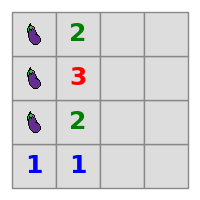

In [19]:
juego = Buscaminas(n,n,bombas)
juego.pintar_todo()
juego.juego_activo = True
agente = Agente(juego, base_conocimiento, descriptor, True)

In [20]:
agente.buscaminas.juego_activo = True
agente.jugar()

Estoy buscando para empezar... (0,2).
mapa del juego hasta el momento: 
[[0 2 0 0]
 [0 3 0 0]
 [0 2 0 0]
 [0 1 0 0]]
Borde conocido: [(0, 1), (1, 1), (2, 1), (3, 1)]


  0%|          | 0/4 [00:00<?, ?it/s]

hay 1815 formulas
Explorando... (0, 1)
	 Adyacentes desconocidas:  [(1, 0), (0, 0)]
		 Query sobre (1, 0)
		 BIEEEN!!! Encontré mina en (1, 0)
mapa del juego hasta el momento: 
[[ 0  2  0  0]
 [11  3  0  0]
 [ 0  2  0  0]
 [ 0  1  0  0]]
Borde conocido: [(0, 1), (1, 1), (2, 1), (3, 1)]


  0%|          | 0/4 [00:00<?, ?it/s]

hay 1815 formulas
Explorando... (0, 1)
	 Adyacentes desconocidas:  [(0, 0)]
		 Query sobre (0, 0)
		 BIEEEN!!! Encontré mina en (0, 0)
mapa del juego hasta el momento: 
[[11  2  0  0]
 [11  3  0  0]
 [ 0  2  0  0]
 [ 0  1  0  0]]
Borde conocido: [(0, 1), (1, 1), (2, 1), (3, 1)]


  0%|          | 0/4 [00:00<?, ?it/s]

hay 1815 formulas
Explorando... (0, 1)
	 Adyacentes desconocidas:  []
hay 2216 formulas
Explorando... (1, 1)
	 Adyacentes desconocidas:  [(2, 0)]
		 Query sobre (2, 0)
		 BIEEEN!!! Encontré mina en (2, 0)
mapa del juego hasta el momento: 
[[11  2  0  0]
 [11  3  0  0]
 [11  2  0  0]
 [ 0  1  0  0]]
Borde conocido: [(0, 1), (1, 1), (2, 1), (3, 1)]


  0%|          | 0/4 [00:00<?, ?it/s]

hay 1815 formulas
Explorando... (0, 1)
	 Adyacentes desconocidas:  []
hay 2216 formulas
Explorando... (1, 1)
	 Adyacentes desconocidas:  []
hay 1992 formulas
Explorando... (2, 1)
	 Adyacentes desconocidas:  [(3, 0)]
		 Query sobre (3, 0)
		 No pude confirmar mina en (3, 0)
		 WOOOOW :OOO. Pude expandir en (3, 0)


True

Como se puede ver en el log narrativo del juego en múltiples ocasiones el agente detecta muy muy bien dónde hay minas y las marca, así como donde es seguro expandir, sin embargo cerca al final siempre se confunde y toca una bomba, otras veces el criterio de victoria o terminación del juego nos molesta y termina el juego antes de tiempo.

# Hora de ver los resultados 🥶

Aquí hacemos primero una función para medir al agente en diversos tamaños de mapa y a distintos niveles de dificultad, con las mediciones hacemos otra función para mostrarlas gráficamente y en texto.

In [21]:
def medir_agente( nmuestras  = 30,
                  tamaño     = 8,
                  dificultad = 0.20 ):
    
    """
        INPUT:
                - formulas:     lista de formulas para crear la base de conocimiento.
                - nmuestras:    cantidad de mediciones, juegos a jugar.
                - tamaño:       dimensiones del mapa de juego (tamaño x tamaño)
                - dificultad:   proporción de la cantidad total de casillas del mapa que tendrá
                                una bomba.
                                
        OUTPUT:
                - tiempos   -> np.array de dimensiones (nmuestras,). medidas de tiempo de ejecución.
                - resultado -> np.array de dimensiones (nmuestras,). resultado del juego, True para ganó.
    """

    
    informacion = [
                    "hay 1 bandera en",
                    "hay 1 bomba en",
                    "hay 0 bombas adyacentes aqui",
                    "hay 1 bombas adyacentes aqui",
                    "hay 2 bombas adyacentes aqui",
                    "hay 3 bombas adyacentes aqui",
                    "hay 4 bombas adyacentes aqui",
                    "hay 5 bombas adyacentes aqui",
                    "hay 6 bombas adyacentes aqui",
                    "hay 7 bombas adyacentes aqui",
                    "hay 8 bombas adyacentes aqui",
                    "hay desconocida en",
                    ]

    descriptor = Descriptor(args_lista=[tamaño, tamaño, len(informacion)])

    formulas  = []
    formulas += unicidad_por_casillas(n = tamaño, descriptor = descriptor) 
    formulas += no_hay_minas(n = tamaño, descriptor = descriptor)
    formulas += si_hay_minas(n = tamaño, descriptor = descriptor)
    
    #vectores de tiempos y resultados
    tiempos   = np.zeros(nmuestras)
    resultado = np.zeros(nmuestras, dtype = bool)
    
    bombas   = int(tamaño*tamaño*dificultad) 

    #contador
    for contador in tqdm(list(range(nmuestras))):
        
        base_conocimiento = LPQuery(formulas)
        juego  = Buscaminas(tamaño, tamaño, bombas)
        agente = Agente(juego, base_conocimiento, descriptor, False)
    
        inicio = time()
        resultado[contador] = agente.jugar()
        final  = time()
        
        tiempos[contador] = final - inicio
        clear_output(wait=False)
        
    return tiempos, resultado
    

In [22]:
def graficar_resultados(tiempos: np.array, resultado: np.array):
    
    resultados = np.array(resultado, dtype = int)
    intentos = np.arange(0, resultados.shape[0])
    
    fig, axs = plt.subplots(nrows = 3, ncols = 1)
    fig.tight_layout(pad=1.0)
    
    axs[0].boxplot(tiempos)
    axs[0].set_ylabel("segundos (s)")

    axs[1].plot(tiempos)
    axs[1].plot(np.ones(tiempos.shape)*np.mean(tiempos))
    axs[1].legend(["tiempo (s)", "media (s)"])
    
    axs[2].scatter(intentos, resultados)
    axs[2].legend(["resultado del juego"])
    #axs[2].set_yticks(["pierde", "gana"])

    clear_output(wait=True)
    plt.plot()
    print(f"tiempo medio de ejecución:\t\t {np.mean(tiempos)}")
    print(f"desviación estándar de tiempo de ejecución:\t\t {np.std(tiempos)}")
    print(f"media de victorias:\t\t {np.mean(np.array(resultado, dtype = int))}")

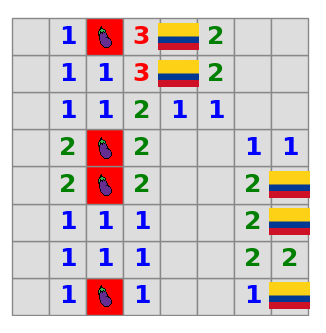

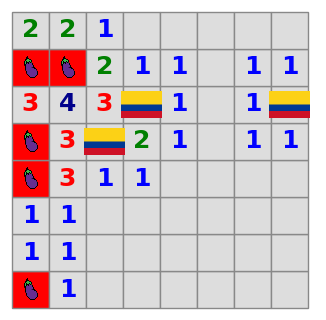

In [23]:
tiempos, resultado = medir_agente(nmuestras  = 2, 
                                  tamaño     = 8,
                                  dificultad = 0.125)

tiempo medio de ejecución:		 59.97132349014282
desviación estándar de tiempo de ejecución:		 17.36713480949402
media de victorias:		 0.0


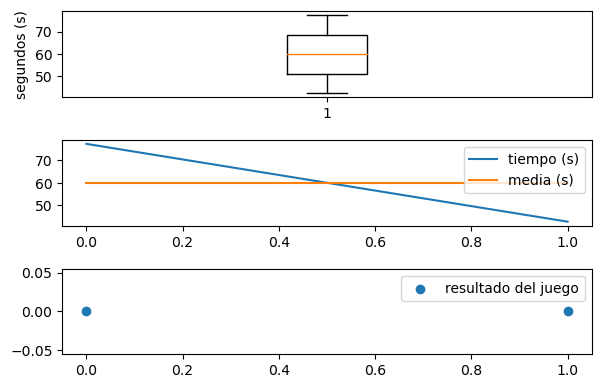

In [24]:
graficar_resultados(tiempos, resultado)

Ahora medimos como se comporta el algoritmo en términos de tiempo de ejecución si el tamaño del problema va creciendo.

In [25]:
def obtener_tendencia_en_tiempo_de_ejecucion(nmuestras = 30, dificultad = 0.2):
    
    inicio = 3
    fin = 14
    paso = 2
    
    tamaños  = np.zeros(len(list(range(inicio, fin, paso))))
    medias_t = np.zeros(len(list(range(inicio, fin, paso))))
    promedios_exito = np.zeros(len(list(range(inicio, fin, paso))))
    
    count = 0
    
    for tamaño in range(inicio, fin, paso):
        
        tiempos, resultado = medir_agente(nmuestras  = nmuestras,
                                          tamaño     = tamaño,
                                          dificultad = dificultad)
        
        media_exitos = np.mean( np.array(resultado, dtype = int) )
        media = np.mean(tiempos)
        
        medias_t[count] = media
        promedios_exito[count] = media_exitos
        tamaños[count]  = tamaño
        
        count += 1
    
    plt.close()
    clear_output(wait=True)
    
    return tamaños, medias_t, promedios_exito
                     

Como verá hay ocasines en que se ven barras de carga y puede que después de un tiempo se quiten todas, cuando se quitan todas indica que una de las muestras de juego se ha completado, y va pasar al próximo intento.

Cada una de las barras de carga que se ven es la cantidad de casillas conocidas cuyas adyacentes ha explorado hasta poder efectuar un cambio efectivo, sea expandir con certeza o marcar con certeza.

In [26]:
tamaños, medias_de_tiempo, medias_exito = obtener_tendencia_en_tiempo_de_ejecucion(nmuestras     = 3, 
                                                                                   dificultad    = 0.25)
clear_output(wait=True)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.scatter(tamaños*tamaños, medias_de_tiempo)
plt.title("Evolución de tiempos de ejecución, para dificultad 25%")
plt.xlabel("Tamaño del problema")
plt.ylabel("Segundos (s)")
plt.savefig('evolucion_tiempos_de_ejecucion_25_porciento_6_muestras.png')

In [ ]:
 plt.scatter(tamaños*tamaños, medias_exito)
plt.title("Evolución de porcentajes de victorias, para dificultad 25%")
plt.xlabel("Tamaño del problema")
plt.ylabel("Segundos (s)")
plt.savefig('evolucion_porcentajes_de_victorias_25_porciento_6_muestras.png')